## Programming and analysis

### Part A: Clustering

Consider the diabetes.csv dataset (available on the course website), which aims to predict whether a patient has diabetes based on various health-related attributes. Normalize data using MinMaxScaler. Always use random_state = 42.

1. Using sklearn, apply K-Means clustering on the normalized data with k = {2, 3, 4, 5, 6, 7, 8, 9, 10, 11}, max_iter = 500. Plot the SSE (sum of squared errors) values for each number of clusters.

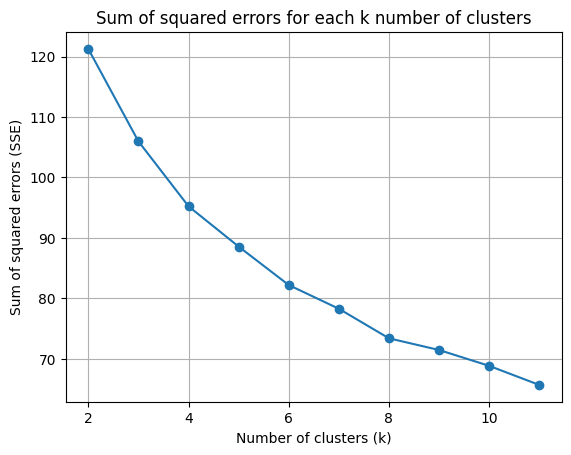

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

dados = pd.read_csv('diabetes.csv')
scaler = MinMaxScaler()
factors = dados.drop('Outcome', axis=1)
factors_scaled = scaler.fit_transform(factors)

k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

k_SSE = []

for k in k_list:
    # .fit() already computes centroids coordinates and assigns points to clusters
    # unlike supervised models, here we want to cluster all the data we have
    # therefore, we don't need to .predict() because there is no new unseen data
    kmeans_model = KMeans(n_clusters=k, max_iter=500, random_state=42).fit(factors_scaled)
    
    # model already stores SSE in its inertia_ attribute
    k_SSE.append(kmeans_model.inertia_)


plt.plot(k_list, k_SSE, marker="o")
plt.title("Sum of squared errors for each k number of clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Sum of squared errors (SSE)")
plt.grid(True)

plt.show()
    

2. Using k=6, assign each observation to a cluster and classify them based on the majority class of the cluster they belong to (Example: If cluster A has 100 observations of class 0 and 99 observations of class 1, classify all 199 observations as the majority class: 0 ). Compute the confusion matrix, accuracy, precision, recall, and F1-score for this classification model. Is this a good classification model? Justify your answer based on your experience with classification models, and discuss the limitations of using clustering for classification tasks.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay


# 1. Data pre-processing

dados = pd.read_csv('diabetes.csv')
scaler = MinMaxScaler()
factors = dados.drop('Outcome', axis=1)
factors_scaled = scaler.fit_transform(factors)

# class is the same as outcomes, both terms refer to the ground truth
outcomes = dados['Outcome']


# 2. Make and train model
kmeans_model = KMeans(n_clusters=6, random_state=42).fit(factors_scaled)


# each index is the number of the cluster
# in each cluster's list the index 0 is the number of observations with outcome 0, and index 1 for outcome 1
class_count_per_cluster = [
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0]
]


# 3. Count how many observations of each class are in each cluster
for obs_index in range(len(kmeans_model.labels_)):
    # the lists labels_ and outcomes have the same length, they both contain all observations
    obs_cluster = kmeans_model.labels_[obs_index]
    obs_class = outcomes[obs_index]
    
    class_count_per_cluster[obs_cluster][obs_class] += 1


# now we have a list like [[61, 73], [254, 26], [43, 26], [19, 16], [74, 51], [49, 76]] for example
#print(class_count_per_cluster)


# each element corresponds to a cluster and has the class of the cluster
class_per_cluster = [0, 0, 0, 0, 0, 0]

# 4. Assign the majority class to each cluster
for cluster in range(6):
    class_zero = class_count_per_cluster[cluster][0]
    class_one = class_count_per_cluster[cluster][1]
    
    # class_per_cluster starts with all clusters as class 0 so we only need to change if there's more class 1 observations
    if class_one > class_zero:
        class_per_cluster[cluster] = 1

        
# class_per_cluster will be like [1, 0, 0, 0, 0, 1] for example
#print(class_per_cluster)


# 5. Assign the majority class of the cluster to each observation depending on which cluster they belong to
outcomes_predicted = []

for obs_cluster in kmeans_model.labels_:
    outcomes_predicted.append(class_per_cluster[obs_cluster])
    

# now we have the list outcomes, which are the real outcomes, and the outcomes_predicted which were predicted
# based on each cluster's majority class

# 6. Compute metrics for the model and print
conf_matrix = confusion_matrix(outcomes, outcomes_predicted)
accuracy = accuracy_score(outcomes, outcomes_predicted)
precision = precision_score(outcomes, outcomes_predicted)
recall = recall_score(outcomes, outcomes_predicted)
f1 = f1_score(outcomes, outcomes_predicted)


print("Confusion Matrix:")
conf_matrix_df = pd.DataFrame(conf_matrix, index=["True 0", "True 1"], columns=["Predicted 0", "Predicted 1"])
display(conf_matrix_df)
print("Accuracy: " + str(round(accuracy, 5)))
print("Precision: " + str(round(precision, 5)))
print("Recall: " + str(round(recall, 5)))
print("F1-score: " + str(round(f1, 5)))


Confusion Matrix:


,Predicted 0,Predicted 1
True 0,390,110
True 1,119,149


Accuracy: 0.70182
Precision: 0.57529
Recall: 0.55597
F1-score: 0.56546


Based on our experience with classification models we can see that this model performed rather poorly. The accuracy, which is the ratio between the number of correctly predicted observations and the total number of observations, is only 70%, existing over 200 wrong predictions. We can also see that the F1-score, which combines both precision and recall, is only about 56% which means there is definitely room for improvement as it is also rather low.

This low performance is due to clustering algorithms having a few shortcomings when it comes to classification tasks. First of all, they struggle to perform well with high-dimensional datasets, like this one for example, as well as datasets with some missing data. Furthermore, the existence of outliers in the dataset is problematic and can significantly affect the model's predictive ability. The same clustering algorithm can also generate different solutions depending on where the centroids are initialized and how they're calculated and overall the computational power needed to compute these algorithm grows quickly as the size of the dataset increases. For these reasons, clustering algorithms are not the best methods to solve classification problems.

3. Print the class distribution and the cluster centers for this model. Choose the 3 most discriminative clusters and interpret the results. What can you conclude about the patients in those clusters?

In [31]:
# Make sure to run code cell of exercise 2. first

import numpy as np



print("\nCluster centers:")

rounded_coords = []
for i in kmeans_model.cluster_centers_:
    rounded_i = [ round(coord, 4) for coord in i ]
    rounded_coords.append(rounded_i)

centers_coords = pd.DataFrame(rounded_coords, columns=factors.columns)
display(centers_coords)

truth_distribution = outcomes.value_counts()
print("\n\nClass distributions")
print("Ground truth:\n0\t" + str(truth_distribution[0]) + "\n1\t" + str(truth_distribution[1]) + "\n")

predicted_truth_dist = pd.DataFrame(outcomes_predicted).value_counts()
print("Predicted outcomes:\n0\t" + str(predicted_truth_dist[0]) + "\n1\t" + str(predicted_truth_dist[1]) + "\n")


purity_per_cluster = {
    '0': 0,
    '1': 0,
    '2': 0,
    '3': 0,
    '4': 0,
    '5': 0
}

for cluster in range(6):
    classes = class_count_per_cluster[cluster]
    purity = max(classes[0], classes[1]) / sum(classes)
    purity_per_cluster[str(cluster)] = purity
    
    print("Cluster " + str(cluster) + ":\n0\t" + str(classes[0]) + "\n1\t" + str(classes[1]) + "\n")

print("Purity per cluster:")
print(purity_per_cluster)


# Most discriminative clusters are the ones with the highest purity so we sort with descending order
# .items() returns a list of (key, value) tuples so to sort by value we use item[1]
purity_per_cluster = dict(sorted(purity_per_cluster.items(), key=lambda item: item[1], reverse=True))

three_most_disc = list(purity_per_cluster.keys())[:3]

print("\nThree most discriminative clusters (highest purity):")
print(*three_most_disc, sep=", ")


Cluster centers:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.1106,0.7511,0.6104,0.3454,0.2477,0.5525,0.2330,0.1354
1,0.1040,0.4980,0.5489,0.2387,0.0693,0.4474,0.1479,0.0698
2,0.3504,0.6794,0.6591,0.0517,0.0096,0.4399,0.1390,0.5969
3,0.2134,0.5920,0.0000,0.0153,0.0000,0.3831,0.1325,0.1619
4,0.2833,0.6184,0.6045,0.0166,0.0109,0.4740,0.1418,0.1960
5,0.5016,0.6527,0.6281,0.3200,0.1427,0.5109,0.1965,0.3812




Class distributions
Ground truth:
0	500
1	268

Predicted outcomes:
0	509
1	259

Cluster 0:
0	61
1	73

Cluster 1:
0	254
1	26

Cluster 2:
0	43
1	26

Cluster 3:
0	19
1	16

Cluster 4:
0	74
1	51

Cluster 5:
0	49
1	76

Purity per cluster:
{'0': 0.5447761194029851, '1': 0.9071428571428571, '2': 0.6231884057971014, '3': 0.5428571428571428, '4': 0.592, '5': 0.608}

Three most discriminative clusters (highest purity):
1, 2, 5


Since the most discriminative clusters are those where the target classes have the biggest difference, they were the  best ones at separating outcomes when compared to the other clusters. Thus, we can conclude that the patients from clusters 1, 2 and 5 are either more diabetic or less diabetic (depending on the majority class of each cluster) than those from the other clusters, i.e the patients from cluster 1 are more similar between themselves and have a similar diagnostic when compared to those of other clusters, for example.   

### Part B: PCA

Using the same dataset with the same normalization.

1. Apply Principal Component Analysis (PCA) and plot the cumulative explained variance by the PCA components. How many principal components should be retained to explain at least 80% of the total variance?

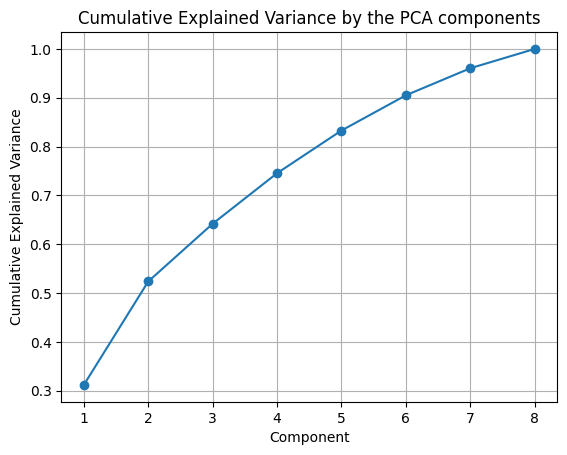

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

dados = pd.read_csv('diabetes.csv')
scaler = MinMaxScaler()
factors = dados.drop('Outcome', axis=1)
factors_scaled = scaler.fit_transform(factors)

outcomes = dados['Outcome']

pca = PCA(n_components=8)
pca.fit(factors_scaled)

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot([ i for i in range(1,9) ], cumulative_explained_variance, marker="o")
plt.title("Cumulative Explained Variance by the PCA components")
plt.xlabel("Component")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

We need to retain 5 principal components in order to explain 80% of the total variance, as the component 4 is already below the 80% mark of cumulative explained variance.

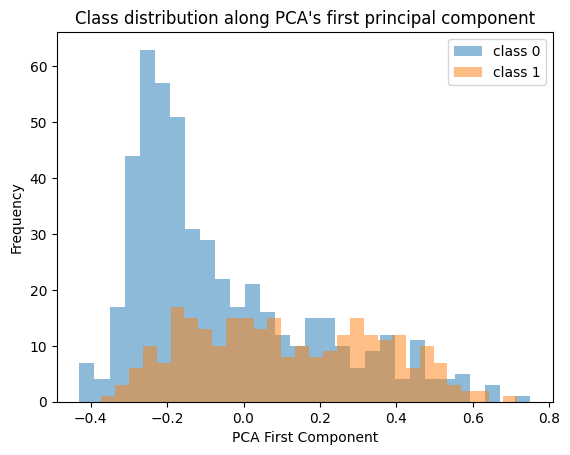

In [72]:
# Make sure to run code from the above cell first

factors_pca = pca.transform(factors_scaled)

first_component = factors_pca[:, 0]


plt.hist(first_component[outcomes == 0], bins=30, alpha=0.5, label="class 0")
plt.hist(first_component[outcomes == 1], bins=30, alpha=0.5, label="class 1")
plt.title("Class distribution along PCA's first principal component")
plt.xlabel("PCA First Component")
plt.ylabel("Frequency")
plt.legend()

plt.show()

We can see there is a higher frequency towards -0.2 from class 0 and this class is more concentrated in this zone, whereas class 1 is more spread out. This suggests lower intraclass variance in class 0. However, both classes still overlap in a significant portion of their histograms' area (most of class 1 is overlapped with class 0) which indicates very poor class seperability, thus leading us to conclude that PCA performed poorly. 

3. Apply Linear Discriminant Analysis (LDA) and plot the class distribution along the LDA component. Comment on the results.

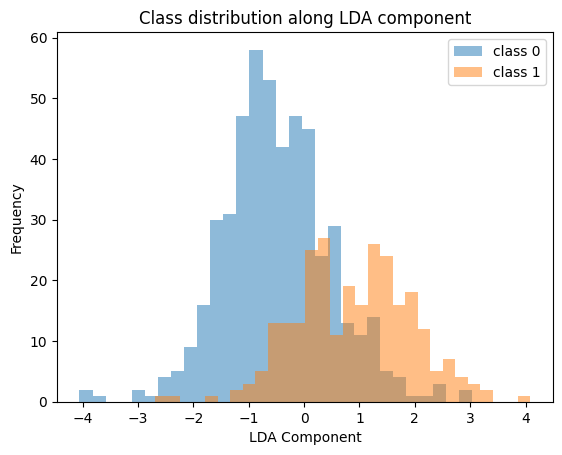

In [71]:
# Make sure to run previous code cells first

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# n_components cannot be larger than min(n_features, n_classes - 1).
lda = LinearDiscriminantAnalysis(n_components=1)

factors_lda = lda.fit(factors_scaled, outcomes).transform(factors_scaled)


plt.hist(factors_lda[outcomes == 0], bins=30, alpha=0.5, label="class 0")
plt.hist(factors_lda[outcomes == 1], bins=30, alpha=0.5, label="class 1")
plt.title("Class distribution along LDA component")
plt.xlabel("LDA Component")
plt.ylabel("Frequency")
plt.legend()

plt.show()

With the LDA method we see a higher frequency and bigger concentration of class 0 near -1 and of class 1 near both 0 and 1. The fact that neither class is very spread out indicates low intraclass variance which is a good sign, and the fact that their overlapped area is not very large indicates good interclass seperability and a good performance from this method.

4. Which of the two methods (PCA or LDA) would be more appropriate for building a discriminant rule? Justify your answer based on the results obtained and explain why that method is more suitable.

Both PCA and LDA are useful dimensionality reduction techniques that differ in the way they work and their underlying principles. We can clearly see that LDA performed better than PCA since there is a much smaller overlap of class 0 and 1 in the histogram of the LDA model.

This is due to the nature of these algorithms. While PCA is an unsupervised learning algorithm, LDA is supervised and thus requires the class labels to work. This key difference is what makes LDA a more suitable model for classification tasks. With the provided class labels, LDA is able to find the directions of maximum class seperability, while PCA can only find directions of maximum variance, regardless of class labels as it doesn't take them into account. Not only that, but this difference also allows LDA to be less sensitive to outliers that may exist within individual classes.

With this we can conclude that if we need a dimensionality reduction algorithm for a classification problem, we are better off using LDA, even though PCA naturally has its own usefulness in other situations. 
